# Capstone Project: Predicting additional tax revenue for the state of Connecticut if sports wagering is legalized

## Table of Contents:
- [Imports](#Imports)
- [Data Cleaning and Exploratory Data Analysis](#Data-Cleaning-and-Exploratory-Data-Analysis)
    - [High-level Checks](#High-Level-Checks)
    - [Data Cleaning](#Data-Cleaning)
    - [Feature Relationship Study](#Feature-Relationship-Study)
    - [Time Series Data Analysis](#Time-Series-Data-Analysis)
    - [Autocorrelation and Partial Autocorrelation Functions](#Autocorrelation-and-Partial-Autocorrelation-Functions)
- [Preprocessing](#Preprocessing)
    - [Autocorrelation and Partial Autocorrelation Functions](#Autocorrelation-and-Partial-Autocorrelation-Functions)
    - [Train-Test-Split](#Train-Test-Split)
- [Modeling](#Modeling)
    - [Baseline Modeling](#Baseline-Modeling)
    - [ARIMAX Modeling](#ARIMAX-Modeling)
    - [Residuals Analysis](#Residuals-Analysis)
    - [Model Comparison](#Model-Comparison)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from warnings import catch_warnings
from warnings import filterwarnings 
import warnings
warnings.simplefilter(action="ignore")

np.random.seed(42)
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Reading in the data

df = pd.read_csv('./data/wv_combined.csv')

In [3]:
# Converting "week_ending" from a object dtype to a datetime64 dtype

df['week_ending'] = pd.to_datetime(df['week_ending'])

In [4]:
# Setting "week_ending" as our index

df.set_index('week_ending', inplace=True)

## Data Cleaning and Exploratory Data Analysis

#### High Level Checks

In [5]:
# Getting basic information on our data

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2019-01-05 to 2019-12-28
Data columns (total 9 columns):
tickets_written            52 non-null int64
 voids                     52 non-null int64
tickets_cashed             52 non-null int64
mobile_taxable_receipts    31 non-null float64
retail_taxable_receipts    52 non-null int64
total_taxable_receipts     52 non-null int64
privilege_tax              52 non-null int64
admin_share                52 non-null int64
state_share                52 non-null int64
dtypes: float64(1), int64(8)
memory usage: 4.1 KB


In [6]:
# Looking at the column names

df.columns

Index(['tickets_written', ' voids  ', 'tickets_cashed',
       'mobile_taxable_receipts', 'retail_taxable_receipts',
       'total_taxable_receipts', 'privilege_tax', 'admin_share',
       'state_share'],
      dtype='object')

In [7]:
# Learning the number of rows and columns of our data

df.shape

(52, 9)

In [8]:
# Getting mathematical breakdowns of each column

df.describe()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
count,52.000,52.000,52.000,31.000,52.000,52.000,52.000,52.000,52.000
mean,3260718.269,70093.481,3912400.519,170215.161,266680.423,368154.865,36815.481,5522.308,31293.192
std,1103890.972,30709.032,2228876.644,221671.646,374279.472,501747.822,50174.777,7526.214,42648.612
min,1110150.000,19058.000,1181917.000,-571570.000,-844841.000,-1416411.000,-141641.000,-21246.000,-120395.000
25%,2202031.000,46195.000,1954432.500,35048.000,126691.250,154329.250,15433.250,2315.000,13118.250
50%,3702858.000,67988.000,3563424.000,149607.000,244725.000,295824.500,29582.500,4437.000,25145.000
75%,4164717.750,91458.250,5706824.000,276460.000,417141.500,681037.000,68103.750,10215.500,57888.250
max,4902465.000,154935.000,9404206.000,601782.000,1388791.000,1664244.000,166424.000,24964.000,141461.000


In [9]:
# Checking data types for each column

df.dtypes

tickets_written              int64
 voids                       int64
tickets_cashed               int64
mobile_taxable_receipts    float64
retail_taxable_receipts      int64
total_taxable_receipts       int64
privilege_tax                int64
admin_share                  int64
state_share                  int64
dtype: object

In [10]:
# Finding null values

df.isnull().sum().sort_values(ascending = False)

mobile_taxable_receipts    21
state_share                 0
admin_share                 0
privilege_tax               0
total_taxable_receipts      0
retail_taxable_receipts     0
tickets_cashed              0
 voids                      0
tickets_written             0
dtype: int64

#### Data Cleaning

In [11]:
# Filling null values with zeros

df.fillna(0, inplace=True)

In [12]:
# Confirming we no longer have null values

df.isnull().sum().sort_values(ascending = False)

state_share                0
admin_share                0
privilege_tax              0
total_taxable_receipts     0
retail_taxable_receipts    0
mobile_taxable_receipts    0
tickets_cashed             0
 voids                     0
tickets_written            0
dtype: int64

In [13]:
# Stripping blank spaces out column titles

df.columns = [col.strip() for col in df.columns]

#### Feature Relationship Study

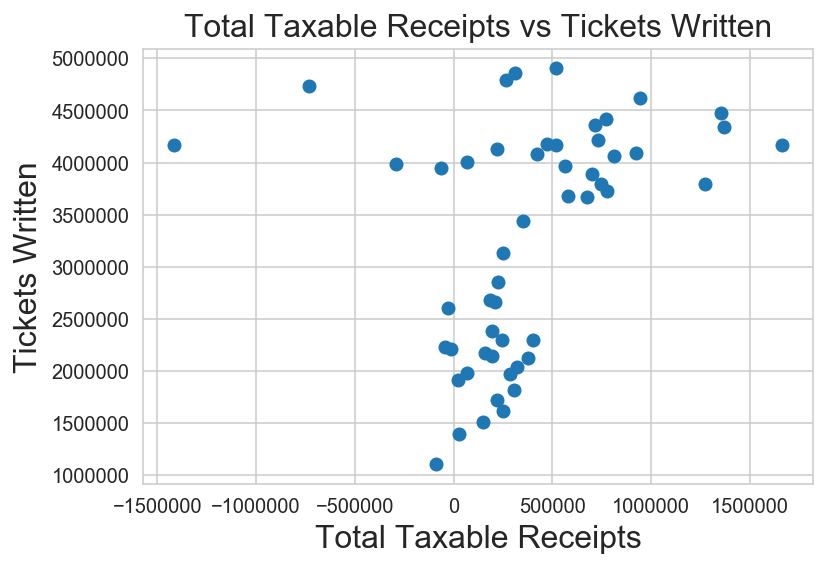

In [14]:
plt.figure(figsize = (6,4))
plt.scatter(df["total_taxable_receipts"],df["tickets_written"])
plt.xlabel("Total Taxable Receipts", fontsize = 16)
plt.ylabel("Tickets Written", fontsize = 16)
plt.title('Total Taxable Receipts vs Tickets Written', fontsize=16);

Generally, the more tickets are written, the higher we can expect total taxable receipts to be.

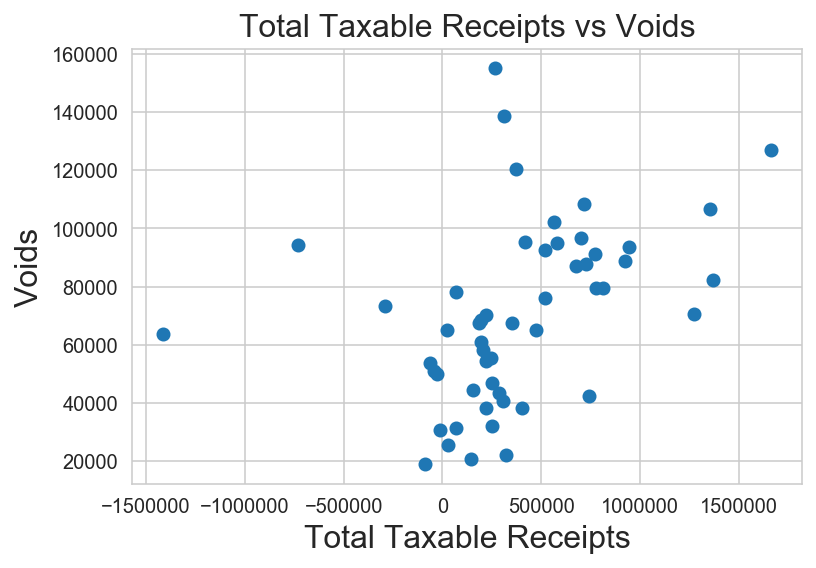

In [15]:
plt.figure(figsize = (6,4))
plt.scatter(df["total_taxable_receipts"],df["voids"])
plt.xlabel("Total Taxable Receipts", fontsize = 16)
plt.ylabel("Voids", fontsize = 16)
plt.title('Total Taxable Receipts vs Voids', fontsize=16);

There is not a strong relationship btween Total Taxable Receipts and Voids. Just because more bets are cancelled out, does not mean we can expect total taxable receipts to be higher or lower

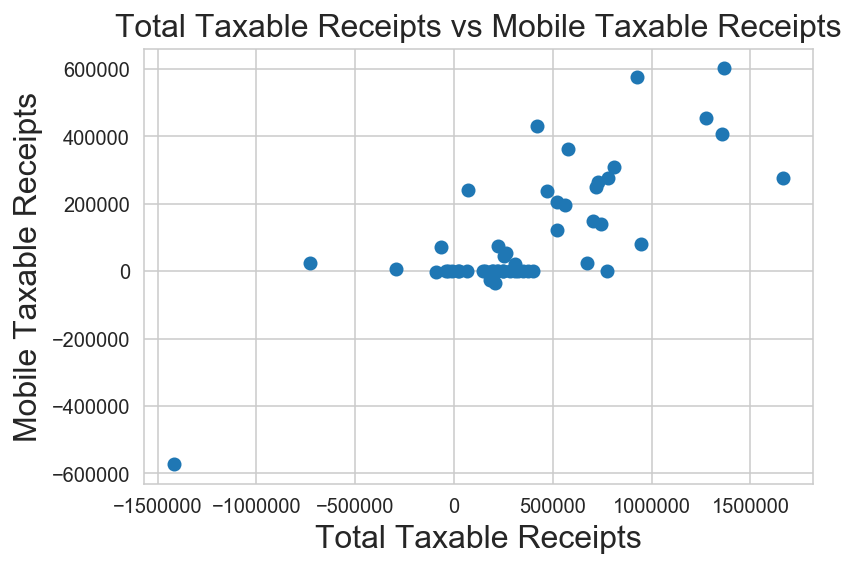

In [16]:
plt.figure(figsize = (6,4))
plt.scatter(df["total_taxable_receipts"],df["mobile_taxable_receipts"])
plt.xlabel("Total Taxable Receipts", fontsize = 16)
plt.ylabel("Mobile Taxable Receipts", fontsize = 16)
plt.title('Total Taxable Receipts vs Mobile Taxable Receipts', fontsize=16);

Generally, mobile taxable receipts increase as total taxable receipts increase. This makes complete sense, as mobile is one of the parts that makes up total. I included this to stress that by improving marketing efforts online, offering individuals more betting options, taxable revenue will likely increase.

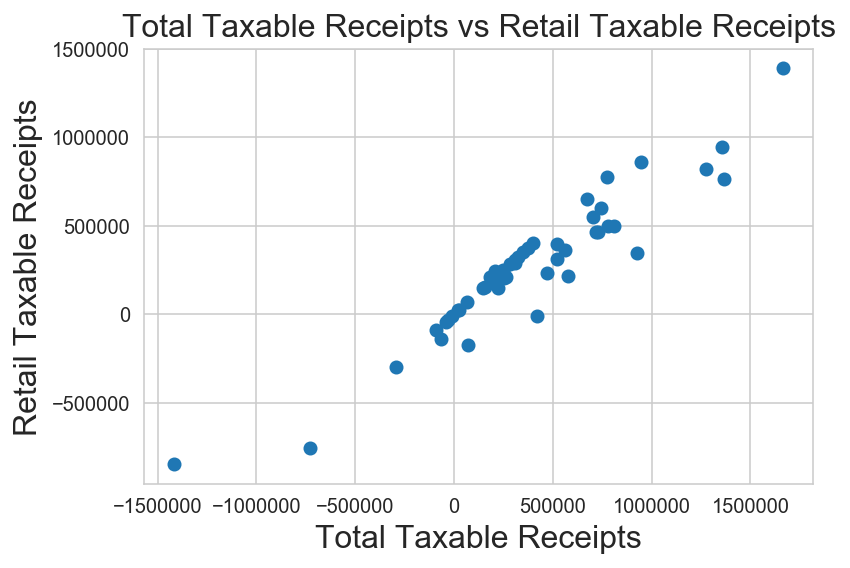

In [17]:
plt.figure(figsize = (6,4))
plt.scatter(df["total_taxable_receipts"],df["retail_taxable_receipts"])
plt.xlabel("Total Taxable Receipts", fontsize = 16)
plt.ylabel("Retail Taxable Receipts", fontsize = 16)
plt.title('Total Taxable Receipts vs Retail Taxable Receipts', fontsize=16);

Generally, retail taxable receipts increase as total taxable receipts increase. This makes complete sense, as retail is one of the parts that makes up total. I included this to stress that by improving marketing efforts on in brick and mortar establishments, offering individuals more betting options, taxable revenue will likely increase.

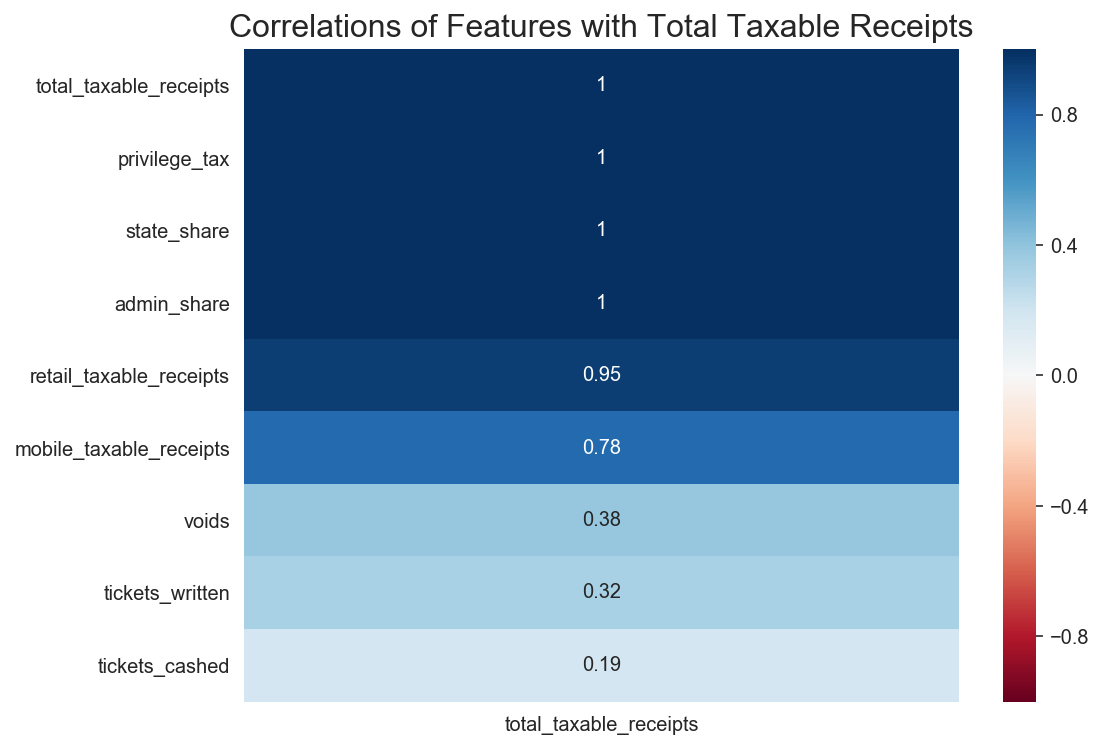

In [18]:
# Heatmap of the corrleations of features and revenue
plt.figure(figsize = (8,6))
plt.title('Correlations of Features with Total Taxable Receipts', fontsize=16);

sns.heatmap(df.corr()[["total_taxable_receipts"]].sort_values(by = 'total_taxable_receipts', ascending = False),
                            annot = True,
                            cmap="RdBu",
                            vmin = -1,
                            vmax = 1);


We are able to confirm several things based on the correlations found in the heatmap above. The features "priveledge_tax", "state_share", and "admin_share" highly correlated with "total_taxable_receipts". When looking more closely at the data, we are able to see that each feature is a percentage of "total_taxable_receipts", leading to a correlation value of 1, as expected. We can also see very high correlations of "retail_taxable_receipts" and "mobile_taxable_receipts" with "total_taxable_receipts". When looking more closely at the data, these features make up the bulk of the total of total_taxable_receipts", hence the high correlation.  We do not see a particularly high correlation with the the remaining three features, "voids", "tickets_written", and "tickets_cashed", but we at least get to learn of the correlation value. If we were to need a correlated feature or two for modeling, we would start with the highest remaining correlated feature, which is "voids", and then continue down the features to take the next most highly correlated feature, and so on, if necessary.

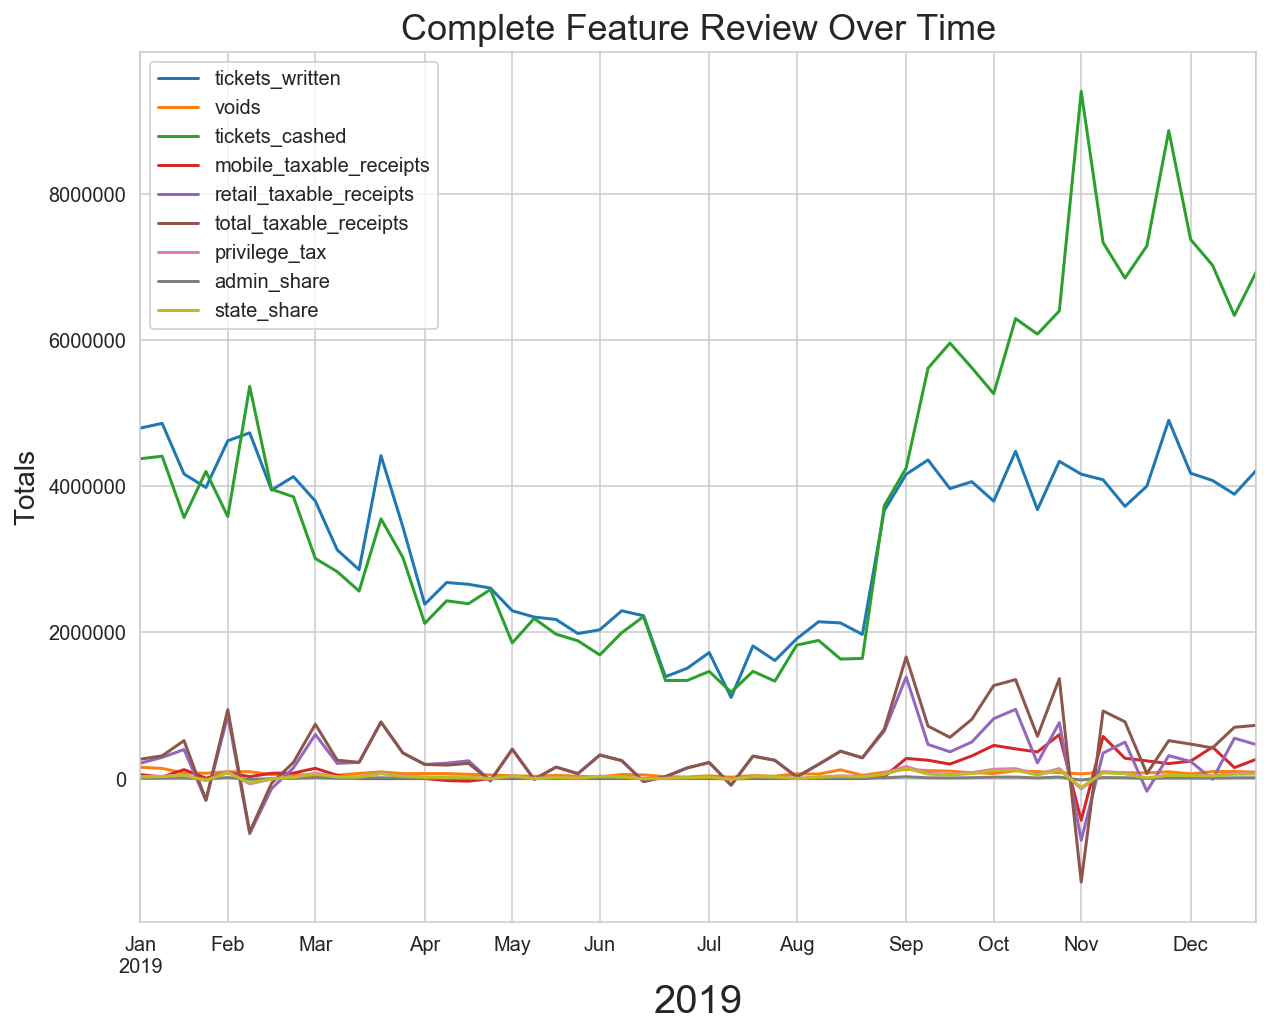

In [19]:
# Plotting all of the features in the data over the 52 weeks the data includes

df.plot(figsize = (10, 8))
plt.xlabel('2019', fontsize = 20)
plt.ylabel('Totals', fontsize = 14)
plt.title('Complete Feature Review Over Time', fontsize = 18)
plt.show();

Given that all of our features are not measured in the same unit, it is important to realize that the plot above is helpful only as a means of noticing trends of features over time. We are not as concerned with the totals of each feature. We just want to use the plot to get a sense of how the features change each month passes in the year 2019

#### Time Series Data Analysis

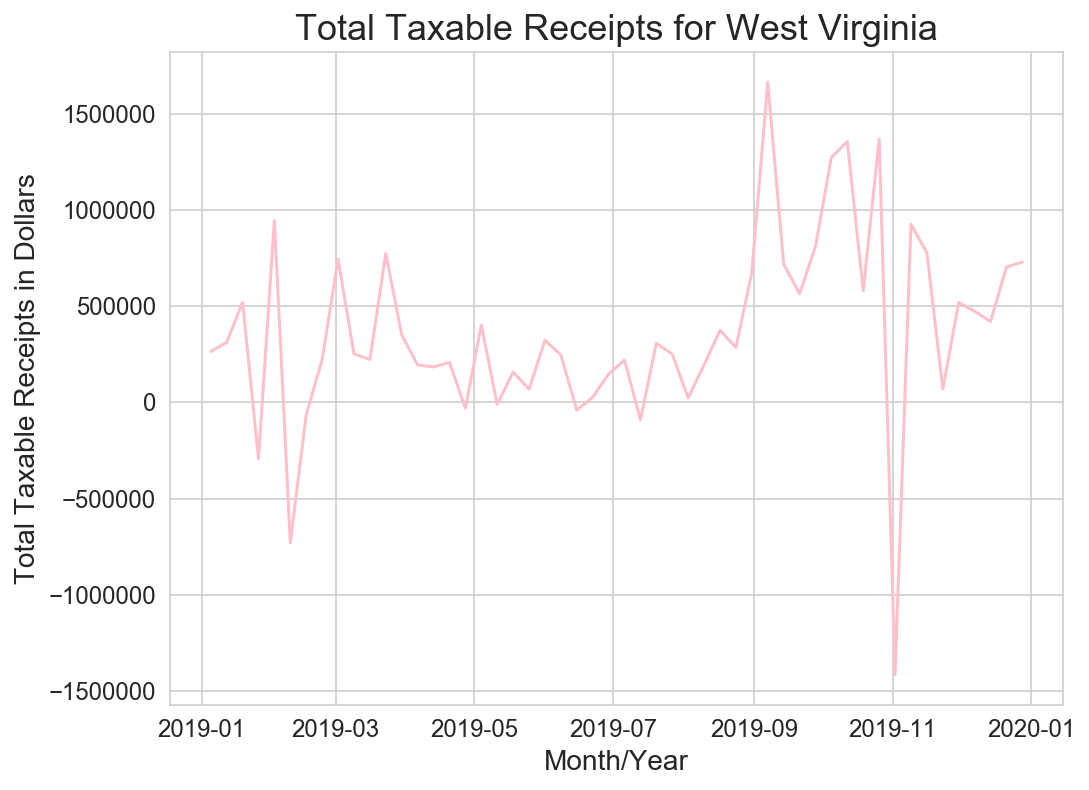

In [20]:
# Line plot for "Total Taxable Receipts" over time

plt.figure(figsize=(8,6))
plt.plot(df['total_taxable_receipts'], color ='pink')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# x-axis is time
plt.xlabel('Month/Year', fontsize=14)

# y-axis is total taxable receipts
plt.ylabel('Total Taxable Receipts in Dollars', fontsize=14)

plt.title('Total Taxable Receipts for West Virginia', fontsize=18);

We can notice somewhat siginiciant spikes in our line that represents the dollar value of total_taxable_receipts over time. This gives us an indication that when it comes time to modeling, we might need to include a moving average value, given that we will want our model to perform as well as possible. Another takeway from the plot is how the line drops below zero a few times. This tells us that during various weeks of the year 2019, the state of West Virginia lost money from sports wagers that were processed. Based on domain knowledge that we have, we know that the most likely scenario where money is lost by the "house" (the entity offering the bets), is when an equal amount of money was not wagered on each side of the bet, resulting in the "house" losing money if the side with a significant more amopunt of money wagered on it ends up being the winning side. Given that the West Virginia Lottery (the provider of the data) does not include the amount wagered on either side of the bet, we aren't able to confirm the assumption we have based on our domain knowledge. More comprehensive data might help us confirm assumptions in the future.

In [21]:
# Calculating rolling means for Total Taxable Receipts

rolling_mean_1  = df['total_taxable_receipts'].rolling(window = 1).mean()
rolling_mean_4 = df['total_taxable_receipts'].rolling(window = 4).mean()
rolling_mean_13 = df['total_taxable_receipts'].rolling(window = 13).mean() 

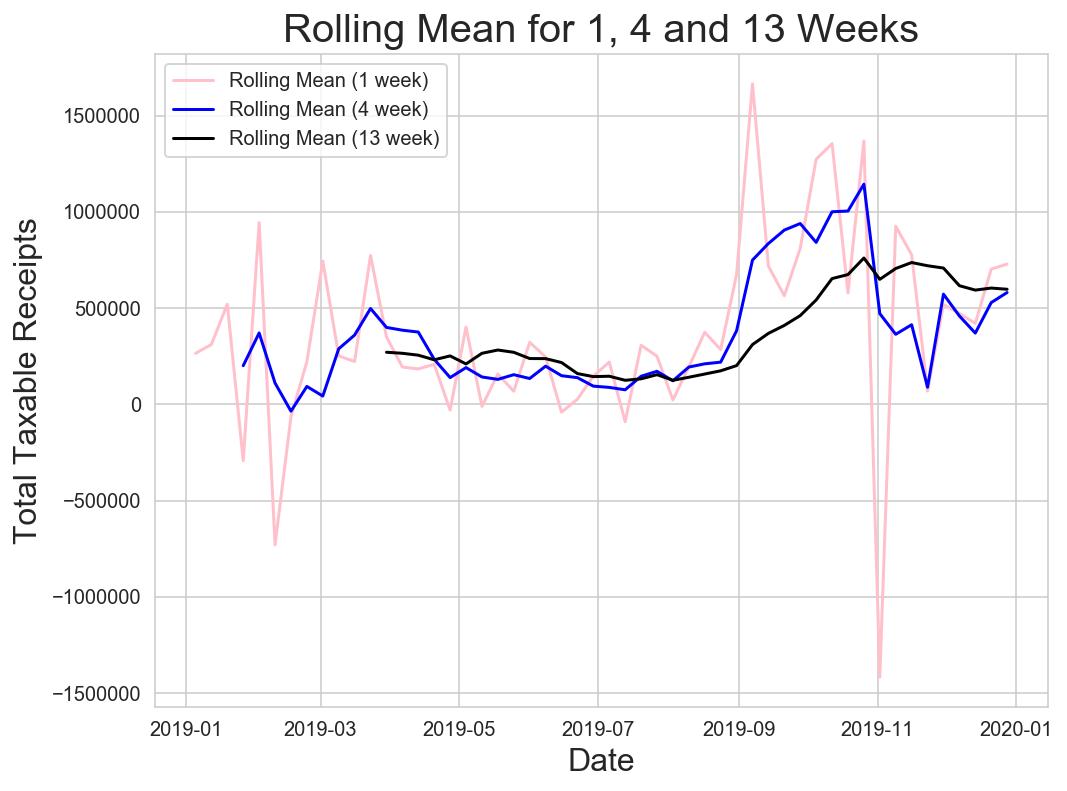

In [22]:
# Plotting rolling means for Total Taxable Receipts

plt.figure(figsize=(8,6))

plt.plot(rolling_mean_1, color='pink', label='Rolling Mean (1 week)')
plt.plot(rolling_mean_4, color='blue', label='Rolling Mean (4 week)')
plt.plot(rolling_mean_13, color='black', label='Rolling Mean (13 week)')

plt.legend(loc='best')

plt.xlabel('Date', fontsize=16)
plt.ylabel('Total Taxable Receipts', fontsize=16)
plt.title('Rolling Mean for 1, 4 and 13 Weeks', fontsize=20);

1 week rolling mean: We see several significant spikes up and down over time. There is quite a large spike up in early September, and a very noticable spike down in late October, which has a large spike back following it, in early November. 

4 week rolling mean: We can see that there are changes over an approximate month of time. Those changes aren't steep spikes like the 1 week rolling mean line shows. but many less than the 1 week rolling mean line shows. The most noticable change is seen as an increase from September until November. This is when the NFL season gets underway.  

13 week rolling mean: We use a 13-week rolling mean to represent an approximate season of the year. The line does not include signficant spikes, but we do see a considerable rise in total taxable receipts in the fall, during the NFL season, when MLB playoffs are underway, and when the NBA season is beginning.  

## Preprocessing

#### Exogenous Feature Processing

In [23]:
# Read in NFL 2018 data
nfl_df_18 = pd.read_csv('./data/nfl-2018-EasternStandardTime.csv')

# Converting Date feature to datetime objects
nfl_df_18['Date'] = pd.to_datetime(nfl_df_18['Date'], dayfirst=True)

# Resampling data to make our the week starting on Wednesday
nfl_count_18 = nfl_df_18.resample('W-Sat', on='Date')[['Home Team']].count()

In [24]:
# Read in NFL  2019 data
nfl_df_19 = pd.read_csv('./data/nfl-2019-EasternStandardTime.csv')

# Converting "Date" feature to datetime objects
nfl_df_19['Date'] = pd.to_datetime(nfl_df_19['Date'], dayfirst=True)

# Resampling data to make our the week starting on Wednesday
nfl_count_19 = nfl_df_19.resample('W-Sat', on='Date')[['Home Team']].count()

In [25]:
# Concatting two dfs to create a combined df
combined_nfl_count = pd.concat([nfl_count_18,nfl_count_19], axis = 0)

# Creating a column from our count
combined_nfl_count.columns = ['nfl_count']

In [26]:
# Read in NBA 2018-2019 data
nba_df = pd.read_csv('./data/nba-2018-EasternStandardTime.csv')

# Converting "Date" feature to datetime objects
nba_df['Date'] = pd.to_datetime(nba_df['Date'], dayfirst=True)

# Resampling data to make our the week starting on Wednesday
nba_count = nba_df.resample('W-Sat', on='Date')[['Home Team']].count()

# Creating a column from our count
nba_count.columns = ['nba_count']

In [27]:
# Adding our nfl_count df to our original df

df = df.join(combined_nfl_count)

# Adding our nba_count df to our original df

df = df.join(nba_count)

In [28]:
# Filling missing values with zeros

df[['nfl_count','nba_count']] = df[['nfl_count','nba_count']].fillna(0)

In [29]:
# Creating new columns with lagged counts

df['nba_count_lag1'] = df['nba_count'].shift(1)

df['nfl_count_lag1'] = df['nfl_count'].shift(1)

In [30]:
df.head()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share,nfl_count,nba_count,nba_count_lag1,nfl_count_lag1
week_ending,,,,,,,,,,,,,
2019-01-05,4796300,154935,4376920,54089.000,210356,264445,26445,3967,22478,16.000,48.000,nan,nan
2019-01-12,4860953,138666,4411529,21356.000,289402,310758,31076,4661,26414,0.000,54.000,48.000,16.000
2019-01-19,4167883,75981,3572071,122956.000,396875,519831,51983,7797,44186,0.000,50.000,54.000,0.000
2019-01-26,3983320,73280,4202907,6185.000,-299052,-292867,-29287,-4393,-24894,0.000,47.000,50.000,0.000
2019-02-02,4622730,93425,3585239,81104.000,862961,944066,94407,14161,80246,0.000,52.000,47.000,0.000


#### Autocorrelation and Partial Autocorrelation Functions

In [31]:
# Ensuring that index is sorted (crucial to avoid our model breaking)

df[['total_taxable_receipts']].sort_index(inplace = True, ascending = True)
df[['total_taxable_receipts']].head()

,total_taxable_receipts
week_ending,
2019-01-05,264445
2019-01-12,310758
2019-01-19,519831
2019-01-26,-292867
2019-02-02,944066


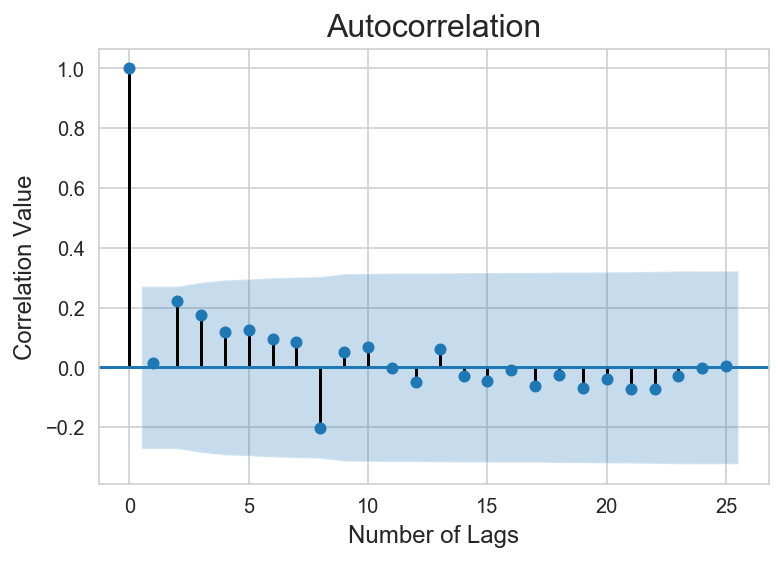

In [32]:
# Plot showing how our Y is correlated vs its lagged-self for 25 weeks 

plot_acf(df[['total_taxable_receipts']], lags = 25)
plt.xlabel("Number of Lags", fontsize=12)
plt.ylabel("Correlation Value", fontsize=12)
plt.title("Autocorrelation", fontsize = 16);

The blue band of an ACF plot indicates the 95% confidence interval for correlations between each lag and the original target. We can see that all of our pertinent data falls within that confidence interval. There are no signficant correlations, meaning, there are no spikes outside the 95% confidence interval, between sequential observations for ~ 2 week lags. 

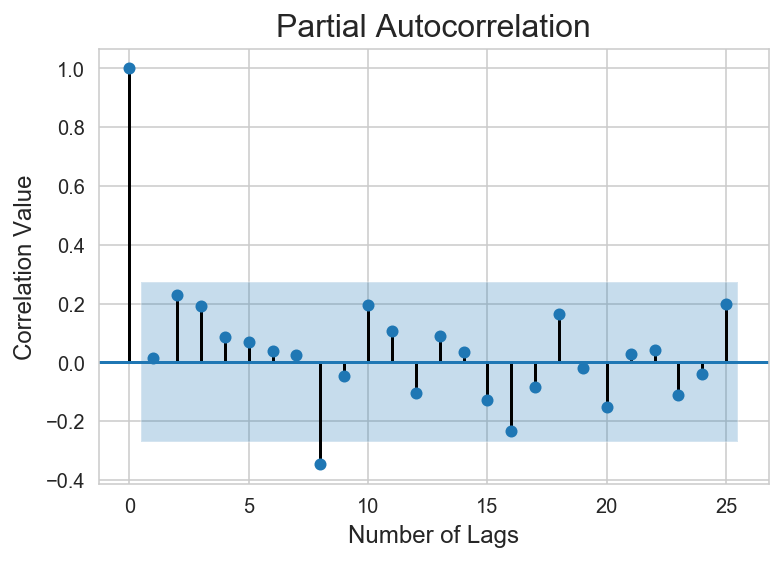

In [33]:
# Plot showing how partially our Y is correlated vs its lagged self for 25 weeks 

plot_pacf(df['total_taxable_receipts'], lags = 25);
plt.xlabel("Number of Lags", fontsize=12)
plt.ylabel("Correlation Value", fontsize=12)
plt.title("Partial Autocorrelation", fontsize = 16);

We are able to see the correlations at given lags. These correlations are drawn after we have removed the effect of correlations due to the terms of shorter lags. We see that most of our data falls within the 95% confidence interval. While we do see some spikes, we can't conclude there is seasonality. We really need more data to analyze before making a seasonality conclusion.

#### Train-Test-Split

In [34]:
df['nba_count_lag1'] = df['nba_count'].shift(1)

df['nfl_count_lag1'] = df['nfl_count'].shift(1)

In [35]:
# Using a 75-25 split, our training set will be 39 rows and our test will be 13 rows

train = df.iloc[:40,]
test = df.iloc[40:,]

In [36]:
def train_test_plot(train, test):
    plt.figure(figsize=(10,6))
    plt.plot(train, c='pink')
    plt.plot(test, c='blue');
    plt.xlabel('Date')
    plt.ylabel(test.columns.values[0])

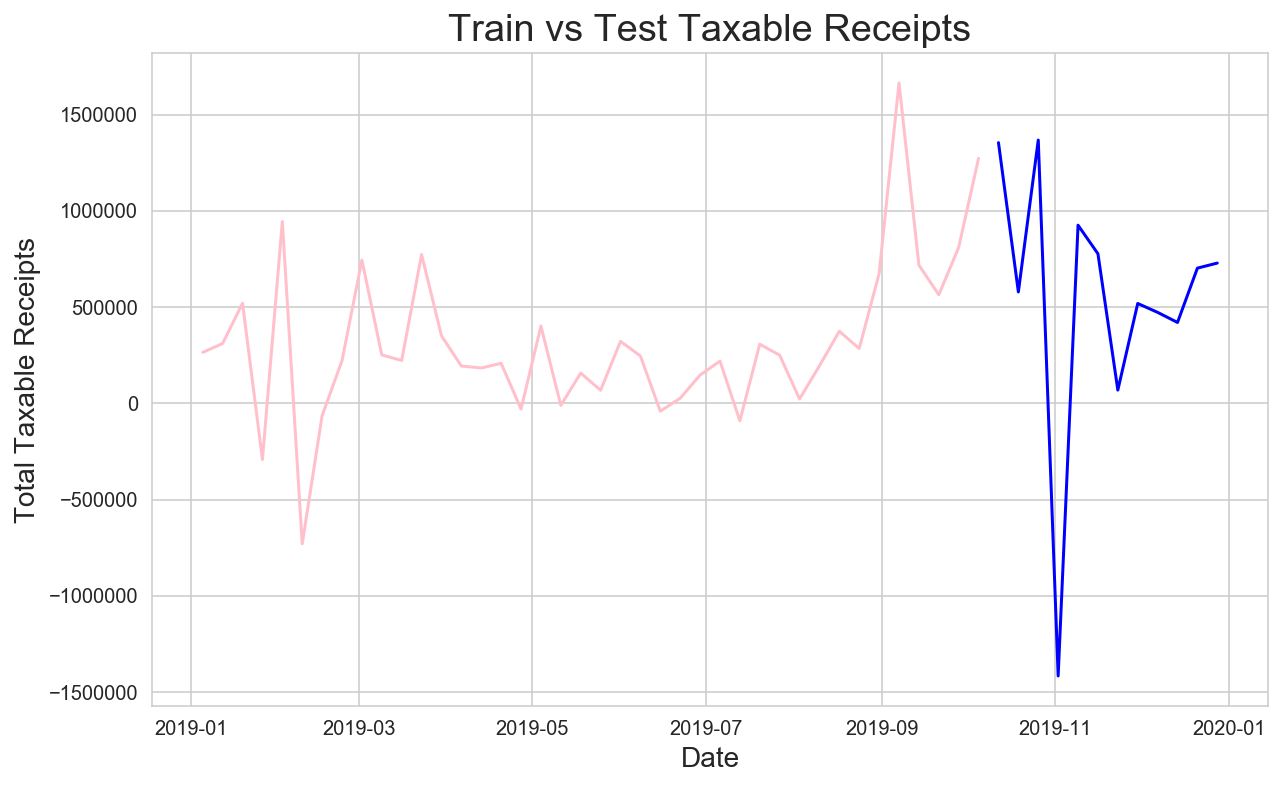

In [37]:
train_test_plot(train[['total_taxable_receipts']], test[['total_taxable_receipts']])
plt.ylabel('Total Taxable Receipts', fontsize=14);
plt.xlabel('Date', fontsize=14)
plt.title("Train vs Test Taxable Receipts", fontsize=19);

After splitting, we see the training data representative of the first 75% of the line, whereas the test data is representative of the last 25% of the line.

## Modeling

#### Baseline Modeling

In [38]:
# Finding the mean of total taxable receipts in our train data

train_mean = train['total_taxable_receipts'].mean()

In [39]:
# Setting our baseline predictions

baseline_preds = [train_mean for i in test['total_taxable_receipts']]

In [40]:
# Baseline Root Mean Squared Error

base_rmse = mean_squared_error(test['total_taxable_receipts'].values, baseline_preds)**0.5

In [41]:
print(f'Our Baseline Model has a Root Mean Squared Error of: {base_rmse}')

Our Baseline Model has a Root Mean Squared Error of: 724164.1823981728


#### ARIMAX Modeling

In [42]:
# Gridsearching to find the optimal number of autoregressive terms (p), the number of nonseasonal differences (d),
# and the number of the moving-average terms (q)
# Nested for loops idea from Jason Brownlee

old_score = 1000000000000000000000

for p in range(3):
    for d in range(2):
        for q in range(3):
            # instantiate SARIMAX model
            model = SARIMAX(endog = train['total_taxable_receipts'][1:],
                            exog = train[['nba_count_lag1', 'nfl_count_lag1']][1:],
                            order = (p,d,q),
                            seasonal_order = (0,0,0,0)).fit()
            # predict
            y_hat = model.predict(start = test.index[1], 
                      end = test.index[-1],
                      exog = test[['nba_count_lag1', 'nfl_count_lag1']])

            # score using root mean squared error
            saved_score = mean_squared_error(test['total_taxable_receipts'].values[1:], y_hat)**.5

            # print scores & parameters
            print(f'P,D,Q values: ({p,d,q}), Root Mean Squared Error: {saved_score}')

            # finding and using our best score
            if saved_score < old_score:
                old_score = saved_score
                best_params = (p,d,q)
                    
# print our best score and associated parameters
print('-----------------------------------------------------------------------')
print(f'Best RMSE achieved: {old_score} with these p,d,q values: {best_params}')

P,D,Q values: ((0, 0, 0)), Root Mean Squared Error: 684243.1837201667
P,D,Q values: ((0, 0, 1)), Root Mean Squared Error: 684243.1837152797
P,D,Q values: ((0, 0, 2)), Root Mean Squared Error: 685713.1658299668
P,D,Q values: ((0, 1, 0)), Root Mean Squared Error: 1066567.9006687454
P,D,Q values: ((0, 1, 1)), Root Mean Squared Error: 817253.8090477335
P,D,Q values: ((0, 1, 2)), Root Mean Squared Error: 865191.2621470432
P,D,Q values: ((1, 0, 0)), Root Mean Squared Error: 684353.6021585062
P,D,Q values: ((1, 0, 1)), Root Mean Squared Error: 796312.525271631
P,D,Q values: ((1, 0, 2)), Root Mean Squared Error: 810455.2659197568
P,D,Q values: ((1, 1, 0)), Root Mean Squared Error: 956422.0331764788
P,D,Q values: ((1, 1, 1)), Root Mean Squared Error: 845852.4206382697
P,D,Q values: ((1, 1, 2)), Root Mean Squared Error: 871947.7006256453
P,D,Q values: ((2, 0, 0)), Root Mean Squared Error: 691714.4126075113
P,D,Q values: ((2, 0, 1)), Root Mean Squared Error: 797563.040167658
P,D,Q values: ((2, 0,

To achieve the "best" RMSE, meaning, the lowest RMSE, we want to feed in p,d,q values of 0,0,1 into our model. In turn, the model will include no autoregressive term(s), no differencing, and one non-seasonal moving average term.  Moving average (q) terms represent lags of the forecast errors. It leads to establish the error of our model as a  combination of the values observed, in the form of values, at points of time in the past. We work to find the optimal p,d,q values with a goal of making our model fit the data as well as it can.

In [43]:
# We determined our optimal p,d,q values above which leads us to fit our model with the recommended parameters

final_model = SARIMAX(endog = train['total_taxable_receipts'][1:],
                            exog = train[['nba_count_lag1', 'nfl_count_lag1']][1:],
                            order = (0,0,1),
                            seasonal_order = (0,0,0,0)).fit()
# predict
y_hat = final_model.predict(start = test.index[1], 
          end = test.index[-1],
          exog = test[['nba_count_lag1', 'nfl_count_lag1']])

# score using root mean squared error
arimax_rmse = mean_squared_error(test['total_taxable_receipts'].values[1:], y_hat)**.5

In [44]:
arimax_rmse

684243.1837152797

In [45]:
# Looking at our predicted values

y_hat

2019-10-19   658019.136
2019-10-26   614151.193
2019-11-02   614151.193
2019-11-09   658019.136
2019-11-16   614151.193
2019-11-23   570283.251
2019-11-30   614151.193
2019-12-07   701887.078
2019-12-14   614151.193
2019-12-21   701887.078
2019-12-28   789622.963
Freq: W-SAT, dtype: float64

#### Residuals Analysis

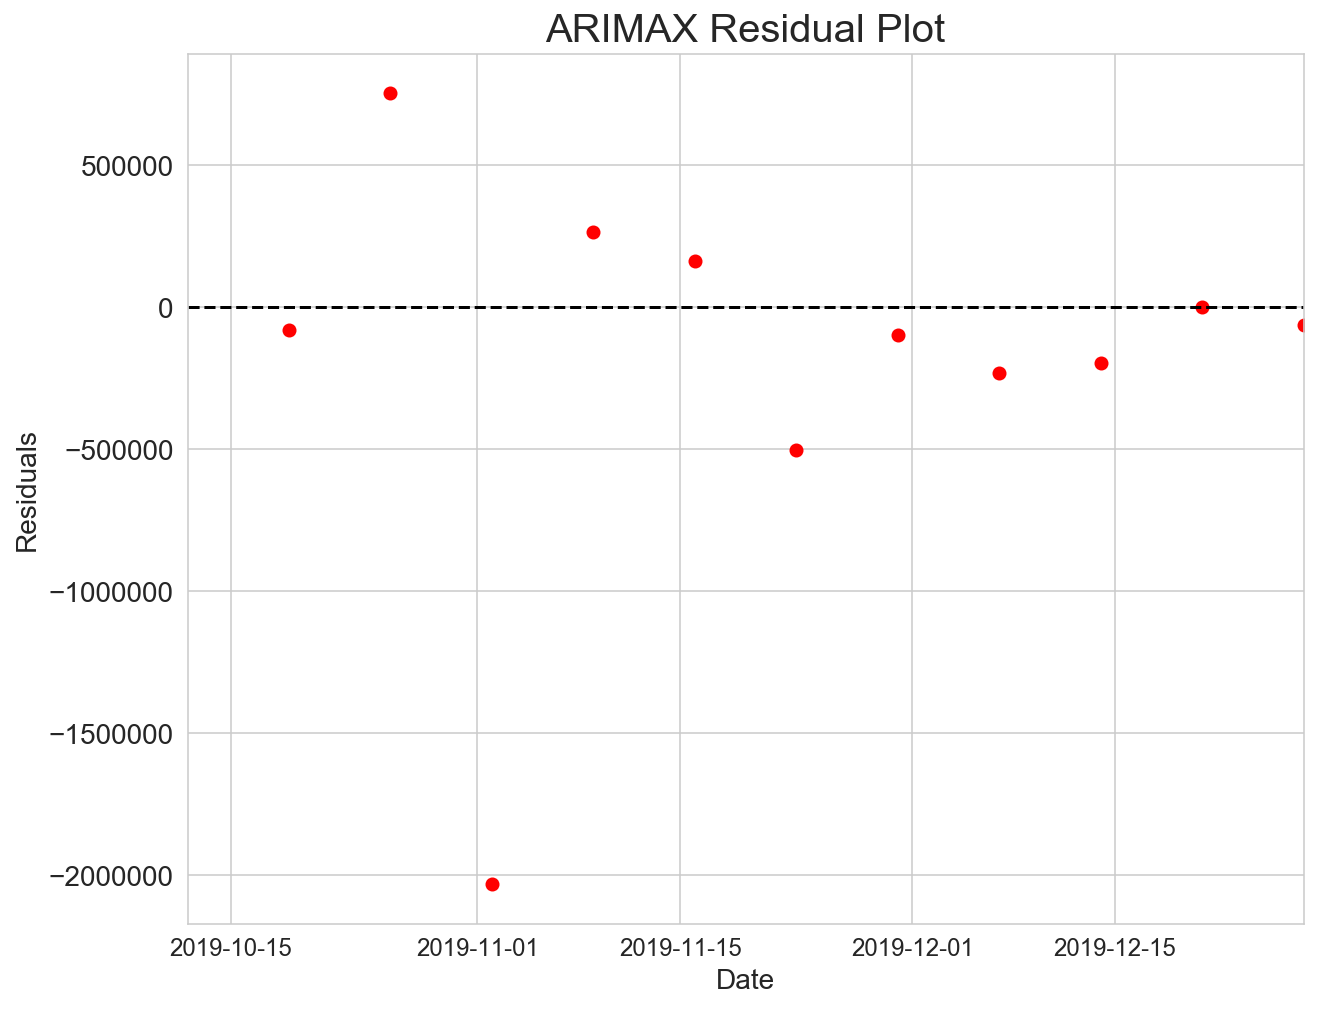

In [46]:
# Calculate and and plot the residuals of our ARIMAX model

# Set figure size
plt.figure(figsize=(10,8))

# Calculate residuals
resids = test['total_taxable_receipts'][1:].values - y_hat.values

# Generate scatterplot of residuals
plt.scatter(test['total_taxable_receipts'][1:].index, resids, c ='red')

# Plot baseline at y=0
plt.hlines(y = 0,
           xmin = test['total_taxable_receipts'].index.min(),
           xmax = test['total_taxable_receipts'].index.max(),
           linestyles = '--')

# Set labels and axes
plt.xticks(fontsize=12)
plt.xlim(test['total_taxable_receipts'].index.min(), test['total_taxable_receipts'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize=14);
plt.xlabel('Date', fontsize=14)
plt.title("ARIMAX Residual Plot", fontsize=20);

There are some days where the prediction is off more than others. This could be specific to those days, or it could be a limit of the model. For example, the residual that we can see at the bottom of the plot above the 2019-11-01 date, our model isn't picking up on the dip in our actual data enough. For the week ending 11/02/19, our odel should predict a negative value but it does not.

#### Model Comparison

In [47]:
print(f'Baseline Model RMSE: {base_rmse}')
print(f'ARIMAX Model RMSE: {arimax_rmse}')

Baseline Model RMSE: 724164.1823981728
ARIMAX Model RMSE: 684243.1837152797


Our score improved as seen by the reduction in RMSE from our baseline model to our ARIMAX model.

## Conclusions and Recommendations

We would love to be able to tell the State Legislature that they should either expect X amount of taxable revenue in a year if they approve sports wagering to the Senate and the Senate, in turn, passest the bill. Leveraging our ARIMAX model, we are able to come up with predicted weekly values of taxable revenue. However, to give the State Legislature a confident yes or no, we really need more data. Given that we were only able to leverage 52 weeks of data and observations, we can't conclude if seasonality exists. The State Legislature would benefit from knowing of seasonality.  Additionally, while our ARIMAX model does outperform a standard baseline model, it doesn't come very close in predicting values based on what we trained the model on.  At certain points in time within the data time period, it made reasonable predictions. At other times, it was way off. We'd like more time to tune our model and possibly bring in additional exogenous features.

We recommend leveraging more resources to continue our analysis. We would like more years of data, more features, and a better idea from the State Legislature how exactly they determine success. All we were told is that they want to decide on whether to approve the bill or not to the Senate. We don't know what is important to them, if there is a certain taxable revenue amount they want to see to approve the bill, etc.

In conclusion, we would like the State Legislature to work more closely with us, for them to help us define "success", to provide us more resources, and more time to conduct a more comprehensive analysis.